<a href="https://www.kaggle.com/code/erwanchesneau/amex-model-averaging-xgboost-cateboost-0-794?scriptVersionId=104597431" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# LOAD LIBRARIES
import os
import gc
import pickle
from copy import deepcopy
import pandas as pd
import numpy as np # CPU libraries
import cudf # GPU libraries

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import Pool, CatBoostClassifier
print('RAPIDS version',cudf.__version__)

RAPIDS version 21.10.01


In [2]:
# VERSION NAME FOR SAVED MODEL FILES
VER = 2

# TRAIN RANDOM SEED
SEED = 42

# FILL NAN VALUE
NAN_VALUE = -127 # will fit in int8

# FOLDS PER MODEL
FOLDS = 5

TRAIN_PATH = '../input/amex-data-integer-dtypes-parquet-format/train.parquet'

ODIR = "/kaggle/working/echesneau/"
if not os.path.isdir(ODIR):
    os.makedirs(ODIR)

TRAIN_SUBSAMPLE = 1.0

result_all = pd.DataFrame(columns=['model', 'preprocessing', 'name', \
                                   'y_valid_pred', 'y_pred','valid_acc', 'acc'])
result_sum = pd.DataFrame(columns=['model', 'preprocessing', 'name', 'y_pred', 'acc'])

In [3]:
def read_file(path = '', usecols = None):
    """
    function to load dataset
    The function is modified frm the original one
    The Fillna is done only during the processing
    """
    # LOAD DATAFRAME
    if usecols is not None:
        data = cudf.read_parquet(path, columns=usecols)
    else:
        data = cudf.read_parquet(path)
    # REDUCE DTYPE FOR CUSTOMER AND DATE
    data['customer_ID'] = data['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
    data.S_2 = cudf.to_datetime( data.S_2 )
    print('shape of data:', data.shape)

    return data

In [4]:
def process_and_feature_engineer(data):
    """
    function to process database
    FEATURE ENGINEERING FROM
    https://www.kaggle.com/code/huseyincot/amex-agg-data-how-it-created
    """
    all_cols = [c for c in list(data.columns) if c not in ['customer_ID','S_2']]
    cat_feat = ["B_30","B_38","D_114","D_116","D_117",\
                    "D_120","D_126","D_63","D_64","D_66","D_68"]
    num_features = [col for col in all_cols if col not in cat_feat]

    test_num_agg = data.groupby("customer_ID")[num_features].agg(['mean', \
                                                                  'std', \
                                                                  'min', \
                                                                  'max', \
                                                                  'last'])
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]

    test_cat_agg = data.groupby("customer_ID")[cat_feat].agg(['count', \
                                                              'last', \
                                                              'nunique'])
    test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]

    data = cudf.concat([test_num_agg, test_cat_agg], axis=1)
    del test_num_agg, test_cat_agg
    data = data.fillna(NAN_VALUE)
    print('shape after engineering', data.shape )
    return data

In [5]:
def amex_metric_mod(y_true, y_pred):
    """
    function to calculate the metric of the competion
    from https://www.kaggle.com/kyakovlev
    and https://www.kaggle.com/competitions/amex-default-prediction/discussion/327534
    """
    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

# @huseyincot preprocessing

The processing proposed by @Huyseioncot seems to be interessting and it is one of the most used.
So we decide to base the predictions on this processing.

## Load and process

Parquet format is use to save GPU/RAM memory.

In [6]:
print('Reading train data...')
train = read_file(path = TRAIN_PATH)

Reading train data...
shape of data: (5531451, 190)


In [7]:
train = process_and_feature_engineer(train)

shape after engineering (458913, 918)


In [8]:
train.head()

,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,D_39_last,...,D_63_nunique,D_64_count,D_64_last,D_64_nunique,D_66_count,D_66_last,D_66_nunique,D_68_count,D_68_last,D_68_nunique
customer_ID,,,,,,,,,,,,,,,,,,,,,
-9223358381327749917,0.415868,0.057145,0.340178,0.498727,0.387708,2.615385,4.628507,0,16,0,...,1,13,2,1,13,-1,1,13,3,2
-9223193039457028513,0.974068,0.013094,0.964483,1.002478,1.001372,0.000000,0.000000,0,0,0,...,2,13,0,1,13,-1,1,13,6,1
-9223189665817919541,0.802447,0.038025,0.694073,0.828761,0.694073,0.000000,0.000000,0,0,0,...,1,13,0,1,13,-1,1,13,6,1
-9223188534444851899,0.791203,0.002688,0.786647,0.794826,0.787945,0.000000,0.000000,0,0,0,...,1,13,3,2,13,-1,1,13,5,1
-9223173911659837606,0.115666,0.078554,0.038207,0.252421,0.040486,4.384615,6.144625,0,17,13,...,1,13,0,2,13,-1,1,13,6,2


Targets are added in the database

In [9]:
# ADD TARGETS
targets = cudf.read_csv('../input/amex-default-prediction/train_labels.csv')
targets['customer_ID'] = targets['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
targets = targets.set_index('customer_ID')
train = train.merge(targets, left_index=True, right_index=True, how='left')
train.target = train.target.astype('int8')
del targets

# NEEDED TO MAKE CV DETERMINISTIC (cudf merge above randomly shuffles rows)
train = train.sort_index().reset_index()

# FEATURES
FEATURES = train.columns[1:-1]
print(f'There are {len(FEATURES)} features!')

There are 918 features!


In [10]:
with open(ODIR+'/all_features.pkl', 'wb') as ofile :
    pickle.dump(FEATURES, ofile)

Features are needed for the prediction on the test set,
we save it.

## XGBoost

XGBoost seems to be one of the most efficent model.

In [11]:
train = train.to_pandas() # free GPU memory
gc.collect()

0

In [12]:
print('XGB Version',xgb.__version__)

# XGB MODEL PARAMETERS
xgb_parms = {
    'max_depth':4,
    'learning_rate':0.05,
    'subsample':0.8,
    'colsample_bytree':0.6,
    'eval_metric':'logloss',
    'objective':'binary:logistic',
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor',
    'random_state':SEED
}

XGB Version 1.6.1


Beause of memory limitation, database is split into flods.
A model is train for each fold.
Amex metric is calculated on the validation set, train set and all fold data.
At the end, the global metric is calculated

In [13]:
oof = []
skf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold,(train_idx, valid_idx) in enumerate(skf.split(
            train, train.target )):
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size',len(train_idx),'Valid size',len(valid_idx))
    print(f'### Training with {int(TRAIN_SUBSAMPLE*100)}% fold data...')
    print('#'*25)
    dtrain = xgb.DMatrix(data=train.loc[train_idx, FEATURES], label=train.loc[train_idx, 'target'])
    dvalid = xgb.DMatrix(data=train.loc[valid_idx, FEATURES], label=train.loc[valid_idx, 'target'])
    model = xgb.train(xgb_parms,
                      dtrain=dtrain,
                      evals=[(dtrain,'train'),(dvalid,'valid')],
                      num_boost_round=9999,
                      #num_boost_round=99,
                      early_stopping_rounds=100,
                      verbose_eval=100)
    model.save_model(f'{ODIR}/XGB_all_features_v{VER}_fold{fold}.xgb')
    valid_pred = model.predict(dvalid)
    val_acc = amex_metric_mod(train.loc[valid_idx, 'target'].values, valid_pred)
    print('Kaggle Metric on valid set =',val_acc,'\n')

    df = train.loc[valid_idx, ['customer_ID','target'] ].copy()
    df['oof_pred'] = valid_pred
    oof.append( df )

    del dtrain, dvalid, df
    _ = gc.collect()

    dall = xgb.DMatrix(data=train[FEATURES], label=train['target'])
    pred = model.predict(dall)
    all_acc = amex_metric_mod(train['target'].values, pred)
    print('Kaggle Metric on all dataset =',all_acc,'\n')
    result_all = result_all.append({'model' : "XGBoost",
                                    'preprocessing' : "huseyincot_all_feat",
                                    'name' : f'XGB_all_features_v{VER}_fold{fold}',
                                    'y_valid_pred' : valid_pred,
                                    'valid_acc' : val_acc,
                                    'y_pred' : pred,
                                    'acc' : all_acc
                                   },
                                   ignore_index=True
                                  )
    del dall, pred, valid_pred
    _ = gc.collect()
print('#'*25)
oof = pd.concat(oof,axis=0,ignore_index=True).set_index('customer_ID')
acc = amex_metric_mod(oof.target.values, oof.oof_pred.values)
result_sum = result_sum.append({'model' : "XGBoost",
                                'preprocessing':"huseyincot_all_feat",
                                'name' : "XGBoost_huseyincot_all_feat",
                                'y_pred' : oof,
                                'acc': acc
                               },
                               ignore_index=True
                              )
print('OVERALL CV Kaggle Metric =',acc)

del oof, acc
_ = gc.collect()

#########################
### Fold 1
### Train size 367130 Valid size 91783
### Training with 100% fold data...
#########################
[0]	train-logloss:0.66272	valid-logloss:0.66266
[100]	train-logloss:0.23674	valid-logloss:0.23923
[200]	train-logloss:0.22239	valid-logloss:0.22728
[300]	train-logloss:0.21634	valid-logloss:0.22324
[400]	train-logloss:0.21232	valid-logloss:0.22119
[500]	train-logloss:0.20918	valid-logloss:0.22006
[600]	train-logloss:0.20646	valid-logloss:0.21929
[700]	train-logloss:0.20401	valid-logloss:0.21872
[800]	train-logloss:0.20179	valid-logloss:0.21838
[900]	train-logloss:0.19961	valid-logloss:0.21806
[1000]	train-logloss:0.19754	valid-logloss:0.21781
[1100]	train-logloss:0.19556	valid-logloss:0.21760
[1200]	train-logloss:0.19357	valid-logloss:0.21742
[1300]	train-logloss:0.19171	valid-logloss:0.21734
[1400]	train-logloss:0.18988	valid-logloss:0.21728
[1500]	train-logloss:0.18807	valid-logloss:0.21721
[1600]	train-logloss:0.18628	valid-logloss:0.21712
[1700]	

## CatBoost

CatBoost is based on the same method than XGBoost but could  be more efficient.
We apply the same code than before but training a catboost.

In [14]:
# GET CATEG VARIABLES
cat_features = ["B_30", "B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
categ = []
#print(train.columns)
for col in train.columns :
    if col not in ['customer_ID', 'target'] :
        VAR = '_'.join(col.split('_')[:2])
        if VAR in cat_features :
            categ.append(col)

In [15]:
oof = []
skf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold,(train_idx, valid_idx) in enumerate(skf.split(
            train, train.target )):
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size',len(train_idx),'Valid size',len(valid_idx))
    print(f'### Training with {int(TRAIN_SUBSAMPLE*100)}% fold data...')
    print('#'*25)
    train_pool = Pool(train.loc[train_idx, FEATURES],
                      train.loc[train_idx, 'target'],
                      cat_features=categ
                     )
    valid_pool = Pool(train.loc[valid_idx, FEATURES],
                      train.loc[valid_idx, 'target'],
                      cat_features=categ
                     )
    model = CatBoostClassifier(iterations=9999,
                               random_state=SEED,
                               task_type="GPU",
                               loss_function = 'Logloss',
                               learning_rate=0.05
                               )
    model.fit(train_pool, eval_set=valid_pool,
              #od_type="Iter",
              early_stopping_rounds=100,
              #od_wait=100,
              verbose=100)
    model.save_model(f'{ODIR}/CTB_all_features_v{VER}_fold{fold}.ctb')
    valid_pred = model.predict_proba(valid_pool)[:,1]
    val_acc = amex_metric_mod(train.loc[valid_idx, 'target'].values, valid_pred)
    print('Kaggle Metric on valid set =',val_acc,'\n')

    df = train.loc[valid_idx, ['customer_ID','target'] ].copy()
    df['oof_pred'] = valid_pred
    oof.append( df )

    del train_pool, valid_pool, df
    _ = gc.collect()

    all_pool = Pool(train[FEATURES],
                    train['target'],
                    cat_features=categ
                     )
    pred = model.predict_proba(all_pool)[:,1]
    all_acc = amex_metric_mod(train['target'].values, pred)
    print('Kaggle Metric on all dataset =',all_acc,'\n')
    result_all = result_all.append({'model' : "CateBoost",
                                    'preprocessing' : "huseyincot_all_feat",
                                    'name' : f'CTB_all_features_v{VER}_fold{fold}',
                                    'y_valid_pred' : valid_pred,
                                    'valid_acc' : val_acc,
                                    'y_pred' : pred,
                                    'acc' : all_acc
                                   },
                                   ignore_index=True
                                  )
    del all_pool, pred, valid_pred
    _ = gc.collect()

print('#'*25)
oof = pd.concat(oof,axis=0,ignore_index=True).set_index('customer_ID')
acc = amex_metric_mod(oof.target.values, oof.oof_pred.values)
result_sum = result_sum.append({'model' : "CateBoost",
                                'preprocessing':"huseyincot_all_feat",
                                'name' : "CTB_huseyincot_all_feat",
                                'y_pred' : oof,
                                'acc': acc
                               },
                               ignore_index=True
                              )
print('OVERALL CV Kaggle Metric =',acc)

del oof, acc
_ = gc.collect()

#########################
### Fold 1
### Train size 367130 Valid size 91783
### Training with 100% fold data...
#########################
0:	learn: 0.6337220	test: 0.6336139	best: 0.6336139 (0)	total: 120ms	remaining: 20m 3s
100:	learn: 0.2306908	test: 0.2325585	best: 0.2325585 (100)	total: 11.2s	remaining: 18m 16s
200:	learn: 0.2234131	test: 0.2263068	best: 0.2263068 (200)	total: 22s	remaining: 17m 52s
300:	learn: 0.2195866	test: 0.2236417	best: 0.2236417 (300)	total: 33.2s	remaining: 17m 49s
400:	learn: 0.2169051	test: 0.2221936	best: 0.2221936 (400)	total: 44s	remaining: 17m 33s
500:	learn: 0.2148451	test: 0.2213693	best: 0.2213693 (500)	total: 54.7s	remaining: 17m 16s
600:	learn: 0.2130150	test: 0.2207341	best: 0.2207341 (600)	total: 1m 6s	remaining: 17m 14s
700:	learn: 0.2114121	test: 0.2201840	best: 0.2201840 (700)	total: 1m 16s	remaining: 16m 58s
800:	learn: 0.2098911	test: 0.2198174	best: 0.2198174 (800)	total: 1m 27s	remaining: 16m 45s
900:	learn: 0.2085943	test: 0.2195417	bes

In [16]:
del train
_=gc.collect()

# Removing Columns with a majority of NaN

The EDA shows us that some features contain huge amount of NaN values.
These features are removed.

## Load Dataset

In [17]:
train = read_file(path = TRAIN_PATH)

shape of data: (5531451, 190)


## Select features

Features are deleted if more than 20% of values are NaN.

In [18]:
counter = train.isnull().sum(axis=0).sort_values(ascending=False)/len(train)*100
rm_nan = counter[counter>20].index
rm_nan = list(rm_nan.to_array())
print(f"{len(rm_nan)}/{len(train.columns)}")

21/190


In [19]:
FEATURES_2 = [col for col in train.columns if col not in rm_nan]

In [20]:
train = train[FEATURES_2]

## Processing

The same processing is applied

In [21]:
train = process_and_feature_engineer(train)

shape after engineering (458913, 813)


In [22]:
# ADD TARGETS
targets = cudf.read_csv('../input/amex-default-prediction/train_labels.csv')
targets['customer_ID'] = targets['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
targets = targets.set_index('customer_ID')
train = train.merge(targets, left_index=True, right_index=True, how='left')
train.target = train.target.astype('int8')
del targets

# NEEDED TO MAKE CV DETERMINISTIC (cudf merge above randomly shuffles rows)
train = train.sort_index().reset_index()


In [23]:
FEATURES_2 = train.columns[1:-1]

In [24]:
with open(ODIR+'/all_features_2.pkl', 'wb') as ofile :
    pickle.dump(FEATURES_2, ofile)

## XGBoost

In [25]:
train = train.to_pandas() # free GPU memory
TRAIN_SUBSAMPLE = 1.0
gc.collect()

0

In [26]:
print('XGB Version',xgb.__version__)

# XGB MODEL PARAMETERS
xgb_parms = {
    'max_depth':4,
    'learning_rate':0.05,
    'subsample':0.8,
    'colsample_bytree':0.6,
    'eval_metric':'logloss',
    'objective':'binary:logistic',
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor',
    'random_state':SEED
}

XGB Version 1.6.1


In [27]:
oof = []
skf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold,(train_idx, valid_idx) in enumerate(skf.split(
            train, train.target )):
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size',len(train_idx),'Valid size',len(valid_idx))
    print(f'### Training with {int(TRAIN_SUBSAMPLE*100)}% fold data...')
    print('#'*25)
    dtrain = xgb.DMatrix(data=train.loc[train_idx, FEATURES_2], \
                        label=train.loc[train_idx, 'target'])
    dvalid = xgb.DMatrix(data=train.loc[valid_idx, FEATURES_2], \
                        label=train.loc[valid_idx, 'target'])
    model = xgb.train(xgb_parms,
                      dtrain=dtrain,
                      evals=[(dtrain,'train'),(dvalid,'valid')],
                      num_boost_round=9999,
                      #num_boost_round=99,
                      early_stopping_rounds=100,
                      verbose_eval=100)
    model.save_model(f'{ODIR}/XGB_nonan_features_v{VER}_fold{fold}.xgb')
    valid_pred = model.predict(dvalid)
    val_acc = amex_metric_mod(train.loc[valid_idx, 'target'].values, valid_pred)
    print('Kaggle Metric on valid set =',val_acc,'\n')

    df = train.loc[valid_idx, ['customer_ID','target'] ].copy()
    df['oof_pred'] = valid_pred
    oof.append( df )

    del dtrain, dvalid, df
    _ = gc.collect()

    dall = xgb.DMatrix(data=train[FEATURES_2], label=train['target'])
    pred = model.predict(dall)
    all_acc = amex_metric_mod(train['target'].values, pred)
    print('Kaggle Metric on all dataset =',all_acc,'\n')
    #result_all = result_all.append({'model' : "XGBoost",
    #                                'preprocessing' : "huseyincot_nonan_feat",
    #                                'name' : f'XGB_nonan_features_v{VER}_fold{fold}',
    #                                'y_valid_pred' : valid_pred,
    #                                'valid_acc' : val_acc,
    #                                'y_pred' : pred,
    #                                'acc' : all_acc
    #                               },
    #                               ignore_index=True
    #                              )
    del dall, pred, valid_pred
    _ = gc.collect()
print('#'*25)
oof = pd.concat(oof,axis=0,ignore_index=True).set_index('customer_ID')
acc = amex_metric_mod(oof.target.values, oof.oof_pred.values)
#result_sum = result_sum.append({'model' : "XGBoost",
#                                'preprocessing':"huseyincot_nonan_feat",
#                                'name' : "XGBoost_huseyincot_nonan_feat",
#                                'y_pred' : oof,
#                                'acc': acc
#                              },
#                               ignore_index=True
#                              )
print('OVERALL CV Kaggle Metric =',acc)

del oof, acc
_ = gc.collect()

#########################
### Fold 1
### Train size 367130 Valid size 91783
### Training with 100% fold data...
#########################
[0]	train-logloss:0.66204	valid-logloss:0.66210
[100]	train-logloss:0.23852	valid-logloss:0.24137
[200]	train-logloss:0.22436	valid-logloss:0.22964
[300]	train-logloss:0.21834	valid-logloss:0.22552
[400]	train-logloss:0.21435	valid-logloss:0.22349
[500]	train-logloss:0.21111	valid-logloss:0.22226
[600]	train-logloss:0.20834	valid-logloss:0.22136
[700]	train-logloss:0.20592	valid-logloss:0.22086
[800]	train-logloss:0.20364	valid-logloss:0.22044
[900]	train-logloss:0.20149	valid-logloss:0.22008
[1000]	train-logloss:0.19943	valid-logloss:0.21982
[1100]	train-logloss:0.19746	valid-logloss:0.21967
[1200]	train-logloss:0.19554	valid-logloss:0.21951
[1300]	train-logloss:0.19373	valid-logloss:0.21935
[1400]	train-logloss:0.19192	valid-logloss:0.21926
[1500]	train-logloss:0.19015	valid-logloss:0.21912
[1600]	train-logloss:0.18838	valid-logloss:0.21902
[1700]	

## CateBoost

In [28]:
# GET CATEG VARIABLES
cat_features = ["B_30", "B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
categ = []
#print(train.columns)
for col in train.columns :
    if col not in ['customer_ID', 'target'] :
        VAR = '_'.join(col.split('_')[:2])
        if VAR in cat_features :
            categ.append(col)

In [29]:
try :
    del all_pool, pred, valid_pred
    _ = gc.collect()
except NameError :
    pass

In [30]:
oof = []
skf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold,(train_idx, valid_idx) in enumerate(skf.split(
            train, train.target )):
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size',len(train_idx),'Valid size',len(valid_idx))
    print(f'### Training with {int(TRAIN_SUBSAMPLE*100)}% fold data...')
    print('#'*25)
    train_pool = Pool(train.loc[train_idx, FEATURES_2],
                      train.loc[train_idx, 'target'],
                      cat_features=categ
                     )
    valid_pool = Pool(train.loc[valid_idx, FEATURES_2],
                      train.loc[valid_idx, 'target'],
                      cat_features=categ
                     )
    model = CatBoostClassifier(iterations=9999,
                               random_state=SEED,
                               task_type="GPU",
                               loss_function = 'Logloss',
                               learning_rate=0.05
                               )
    model.fit(train_pool, eval_set=valid_pool,
              #od_type="Iter",
              early_stopping_rounds=100,
              #od_wait=100,
              verbose=100)
    model.save_model(f'{ODIR}/CTB_nonan_features_v{VER}_fold{fold}.ctb')
    valid_pred = model.predict_proba(valid_pool)[:,1]
    val_acc = amex_metric_mod(train.loc[valid_idx, 'target'].values, valid_pred)
    print('Kaggle Metric on valid set =',val_acc,'\n')

    df = train.loc[valid_idx, ['customer_ID','target'] ].copy()
    df['oof_pred'] = valid_pred
    oof.append( df )

    del train_pool, valid_pool, df
    _ = gc.collect()

    all_pool = Pool(train[FEATURES_2],
                    train['target'],
                    cat_features=categ
                     )
    pred = model.predict_proba(all_pool)[:,1]
    all_acc = amex_metric_mod(train['target'].values, pred)
    print('Kaggle Metric on all dataset =',all_acc,'\n')
    #result_all = result_all.append({'model' : "CateBoost",
    #                                'preprocessing' : "huseyincot_nonan_feat",
    #                                'name' : f'CTB_nonan_features_v{VER}_fold{fold}',
    #                                'y_valid_pred' : valid_pred,
    #                                'valid_acc' : val_acc
    #                                'y_pred' : pred,
    #                                'acc' : all_acc
    #                               },
    #                               ignore_index=True
    #                              )
    del all_pool, pred, valid_pred
    _ = gc.collect()

print('#'*25)
oof = pd.concat(oof,axis=0,ignore_index=True).set_index('customer_ID')
acc = amex_metric_mod(oof.target.values, oof.oof_pred.values)
#result_sum = result_sum.append({'model' : "CateBoost",
#                                'preprocessing':"huseyincot_all_feat",
#                                'name' : "CTB_huseyincot_all_feat",
#                                'y_pred' : oof,
#                                'acc': acc
#                               },
#                               ignore_index=True
#                              )
print('OVERALL CV Kaggle Metric =',acc)

del oof, acc
_ = gc.collect()

#########################
### Fold 1
### Train size 367130 Valid size 91783
### Training with 100% fold data...
#########################
0:	learn: 0.6310359	test: 0.6309017	best: 0.6309017 (0)	total: 154ms	remaining: 25m 40s
100:	learn: 0.2328865	test: 0.2349460	best: 0.2349460 (100)	total: 10.8s	remaining: 17m 35s
200:	learn: 0.2254610	test: 0.2287104	best: 0.2287104 (200)	total: 21.3s	remaining: 17m 16s
300:	learn: 0.2215497	test: 0.2260087	best: 0.2260087 (300)	total: 32.5s	remaining: 17m 27s
400:	learn: 0.2188535	test: 0.2245013	best: 0.2245013 (400)	total: 43s	remaining: 17m 10s
500:	learn: 0.2167790	test: 0.2236371	best: 0.2236371 (500)	total: 53.6s	remaining: 16m 56s
600:	learn: 0.2150166	test: 0.2229886	best: 0.2229886 (600)	total: 1m 4s	remaining: 16m 52s
700:	learn: 0.2134113	test: 0.2224972	best: 0.2224972 (700)	total: 1m 15s	remaining: 16m 38s
800:	learn: 0.2118675	test: 0.2220633	best: 0.2220633 (800)	total: 1m 25s	remaining: 16m 26s
900:	learn: 0.2104838	test: 0.2217320	

In [31]:
del train
_=gc.collect()

# Features importances

A selection of most important features is done using the drop columns importances method.
The goal is to use only most important features for the prediction.

## Load data

In [32]:
train = read_file(path = TRAIN_PATH)

shape of data: (5531451, 190)


In [33]:
train = process_and_feature_engineer(train)

shape after engineering (458913, 918)


In [34]:
# ADD TARGETS
targets = cudf.read_csv('../input/amex-default-prediction/train_labels.csv')
targets['customer_ID'] = targets['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
targets = targets.set_index('customer_ID')
train = train.merge(targets, left_index=True, right_index=True, how='left')
train.target = train.target.astype('int8')
del targets

# NEEDED TO MAKE CV DETERMINISTIC (cudf merge above randomly shuffles rows)
train = train.sort_index().reset_index()

Because of the important size of the train set and in order to spped up the selection,
we select only 1/400 of rows.

In [35]:
train = train.loc[range(int(len(train)/400))]
train=train.to_pandas()
print(train.shape)

(1147, 920)


In [36]:
FEATURES_tmp = train.columns[1:-1]

## Select features

In [40]:
def dropcol_importances(rf_model, data, labels):
    """
    Function to calculate features importances with a random forest model
    """
    rf_model_ = deepcopy(rf_model)
    rf_model_.random_state = 999
    rf_model_.fit(data, labels)
    baseline = rf_model_.oob_score_
    imp = []
    for i, column in enumerate(data.columns):
        print(f"{i}/{len(data.columns)}", end="\r")
        data_tmp = data.drop(column, axis=1)
        rf_model_ = deepcopy(rf_model)
        rf_model_.random_state = 999
        rf_model_.fit(data_tmp, labels)
        oob = rf_model_.oob_score_
        imp.append(baseline - oob)
    imp = np.array(imp)
    out = pd.DataFrame(
            data={'Feature':data.columns,
                  'Importance':imp})
    out = out.set_index('Feature')
    out = out.sort_values('Importance', ascending=True)
    return out

In [41]:
rf = RandomForestClassifier(
         n_estimators=100,
         # better generality with 5
         min_samples_leaf=5,
         n_jobs=-1,
         oob_score=True)
rf.fit(train[FEATURES_tmp], train['target']) # rf must be pre-trained

RandomForestClassifier(min_samples_leaf=5, n_jobs=-1, oob_score=True)

In [42]:
dc_imp = dropcol_importances(rf,train[FEATURES_tmp] , train['target'])

In [43]:
dc_imp

,Importance
Feature,
S_20_min,-0.012206
S_20_last,-0.012206
S_20_max,-0.010462
D_64_count,-0.010462
D_64_nunique,-0.010462
...,...
B_21_mean,0.013078
B_22_std,0.013949
S_13_min,0.014821


The effect of each features on the accuracy is plot here

<AxesSubplot:ylabel='Feature'>

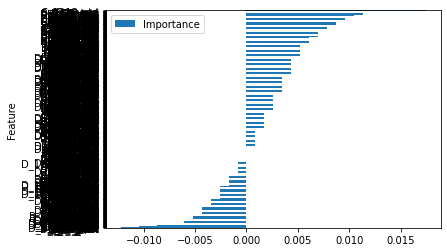

In [44]:
dc_imp.plot.barh()

Only features with an importance > 0 are conserved

In [45]:
dc_imp[dc_imp["Importance"]>0]

,Importance
Feature,
B_2_max,0.000872
D_103_min,0.000872
S_7_last,0.000872
B_12_last,0.000872
R_10_std,0.000872
...,...
B_21_mean,0.013078
B_22_std,0.013949
S_13_min,0.014821


In [46]:
FEATURES_3 = dc_imp[dc_imp["Importance"]>0].index.to_list()
with open(ODIR+'/all_features_3.pkl', 'wb') as ofile :
    pickle.dump(FEATURES_3, ofile)

In [47]:
MODEL_PATH = "../input/amex-output-echesneau"
if os.path.isfile(MODEL_PATH+"/all_features_3.pkl") :
    with open(MODEL_PATH+"/all_features_3.pkl", 'rb') as f :
        FEATURES_3 = pickle.load(f)

## prepare data for modelization

The same processing is then applY.

In [48]:
train = read_file(path = TRAIN_PATH)
train = process_and_feature_engineer(train)

shape of data: (5531451, 190)
shape after engineering (458913, 918)


In [49]:
# ADD TARGETS
targets = cudf.read_csv('../input/amex-default-prediction/train_labels.csv')
targets['customer_ID'] = targets['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
targets = targets.set_index('customer_ID')
train = train.merge(targets, left_index=True, right_index=True, how='left')
train.target = train.target.astype('int8')
del targets

# NEEDED TO MAKE CV DETERMINISTIC (cudf merge above randomly shuffles rows)
train = train.sort_index().reset_index()


## XGBoost

In [50]:
train = train.to_pandas() # free GPU memory
TRAIN_SUBSAMPLE = 1.0
gc.collect()

90

In [51]:
print('XGB Version',xgb.__version__)

# XGB MODEL PARAMETERS
xgb_parms = {
    'max_depth':4,
    'learning_rate':0.05,
    'subsample':0.8,
    'colsample_bytree':0.6,
    'eval_metric':'logloss',
    'objective':'binary:logistic',
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor',
    'random_state':SEED
}

XGB Version 1.6.1


In [52]:
oof = []
skf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold,(train_idx, valid_idx) in enumerate(skf.split(
            train, train.target )):
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size',len(train_idx),'Valid size',len(valid_idx))
    print(f'### Training with {int(TRAIN_SUBSAMPLE*100)}% fold data...')
    print('#'*25)
    dtrain = xgb.DMatrix(data=train.loc[train_idx, FEATURES_3], \
                        label=train.loc[train_idx, 'target'])
    dvalid = xgb.DMatrix(data=train.loc[valid_idx, FEATURES_3], \
                         label=train.loc[valid_idx, 'target'])
    model = xgb.train(xgb_parms,
                      dtrain=dtrain,
                      evals=[(dtrain,'train'),(dvalid,'valid')],
                      num_boost_round=9999,
                      #num_boost_round=99,
                      early_stopping_rounds=100,
                      verbose_eval=100)
    model.save_model(f'{ODIR}/XGB_dc0_features_v{VER}_fold{fold}.xgb')
    valid_pred = model.predict(dvalid)
    val_acc = amex_metric_mod(train.loc[valid_idx, 'target'].values, valid_pred)
    print('Kaggle Metric on valid set =',val_acc,'\n')

    df = train.loc[valid_idx, ['customer_ID','target'] ].copy()
    df['oof_pred'] = valid_pred
    oof.append( df )

    del dtrain, dvalid, df
    _ = gc.collect()

    dall = xgb.DMatrix(data=train[FEATURES_3], label=train['target'])
    pred = model.predict(dall)
    all_acc = amex_metric_mod(train['target'].values, pred)
    print('Kaggle Metric on all dataset =',all_acc,'\n')
    #result_all = result_all.append({'model' : "XGBoost",
    #                                'preprocessing' : "huseyincot_dc0_feat",
    #                                'name' : f'XGB_dc0_features_v{VER}_fold{fold}',
    #                                'y_valid_pred' : valid_pred,
    #                                'valid_acc' : val_acc,
    #                                'y_pred' : pred,
    #                                'acc' : all_acc
    #                               },
    #                               ignore_index=True
    #                              )
    del dall, pred, valid_pred
    _ = gc.collect()
print('#'*25)
oof = pd.concat(oof,axis=0,ignore_index=True).set_index('customer_ID')
acc = amex_metric_mod(oof.target.values, oof.oof_pred.values)
#result_sum = result_sum.append({'model' : "XGBoost",
#                                'preprocessing':"huseyincot_dc0_feat",
#                                'name' : "XGBoost_huseyincot_dc0_feat",
#                                'y_pred' : oof,
#                                'acc': acc
#                              },
#                               ignore_index=True
#                              )
print('OVERALL CV Kaggle Metric =',acc)

del oof, acc
_ = gc.collect()

#########################
### Fold 1
### Train size 367130 Valid size 91783
### Training with 100% fold data...
#########################
[0]	train-logloss:0.66208	valid-logloss:0.66215
[100]	train-logloss:0.23774	valid-logloss:0.24044
[200]	train-logloss:0.22381	valid-logloss:0.22898
[300]	train-logloss:0.21815	valid-logloss:0.22516
[400]	train-logloss:0.21436	valid-logloss:0.22322
[500]	train-logloss:0.21139	valid-logloss:0.22206
[600]	train-logloss:0.20885	valid-logloss:0.22138
[700]	train-logloss:0.20657	valid-logloss:0.22080
[800]	train-logloss:0.20445	valid-logloss:0.22044
[900]	train-logloss:0.20238	valid-logloss:0.22012
[1000]	train-logloss:0.20036	valid-logloss:0.21988
[1100]	train-logloss:0.19849	valid-logloss:0.21970
[1200]	train-logloss:0.19671	valid-logloss:0.21951
[1300]	train-logloss:0.19498	valid-logloss:0.21944
[1400]	train-logloss:0.19326	valid-logloss:0.21941
[1500]	train-logloss:0.19155	valid-logloss:0.21937
[1600]	train-logloss:0.18988	valid-logloss:0.21930
[1700]	

## CateBoost

In [53]:
# GET CATEG VARIABLES
cat_features = ["B_30", "B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
categ = []
#print(train.columns)
for col in FEATURES_3 :
    if col not in ['customer_ID', 'target'] :
        VAR = '_'.join(col.split('_')[:2])
        if VAR in cat_features :
            categ.append(col)

In [54]:
oof = []
skf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold,(train_idx, valid_idx) in enumerate(skf.split(
            train, train.target )):
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size',len(train_idx),'Valid size',len(valid_idx))
    print(f'### Training with {int(TRAIN_SUBSAMPLE*100)}% fold data...')
    print('#'*25)
    train_pool = Pool(train.loc[train_idx, FEATURES_3],
                      train.loc[train_idx, 'target'],
                      cat_features=categ
                     )
    valid_pool = Pool(train.loc[valid_idx, FEATURES_3],
                      train.loc[valid_idx, 'target'],
                      cat_features=categ
                     )
    model = CatBoostClassifier(iterations=9999,
                               random_state=SEED,
                               task_type="GPU",
                               loss_function = 'Logloss',
                               learning_rate=0.05
                               )
    model.fit(train_pool, eval_set=valid_pool,
              #od_type="Iter",
              early_stopping_rounds=100,
              #od_wait=100,
              verbose=100)
    model.save_model(f'{ODIR}/CTB_dc0_features_v{VER}_fold{fold}.ctb')
    valid_pred = model.predict_proba(valid_pool)[:,1]
    val_acc = amex_metric_mod(train.loc[valid_idx, 'target'].values, valid_pred)
    print('Kaggle Metric on valid set =',val_acc,'\n')

    df = train.loc[valid_idx, ['customer_ID','target'] ].copy()
    df['oof_pred'] = valid_pred
    oof.append( df )

    del train_pool, valid_pool, df
    _ = gc.collect()

    all_pool = Pool(train[FEATURES_3],
                    train['target'],
                    cat_features=categ
                     )
    pred = model.predict_proba(all_pool)[:,1]
    all_acc = amex_metric_mod(train['target'].values, pred)
    print('Kaggle Metric on all dataset =',all_acc,'\n')
    #result_all = result_all.append({'model' : "CateBoost",
    #                                'preprocessing' : "huseyincot_dc0_feat",
    #                                'name' : f'CTB_dc0_features_v{VER}_fold{fold}',
    #                                'y_valid_pred' : valid_pred,
    #                                'valid_acc' : val_acc,
    #                                'y_pred' : pred,
    #                                'acc' : all_acc
    #                               },
    #                               ignore_index=True
    #                              )
    del all_pool, pred, valid_pred
    _ = gc.collect()

print('#'*25)
oof = pd.concat(oof,axis=0,ignore_index=True).set_index('customer_ID')
acc = amex_metric_mod(oof.target.values, oof.oof_pred.values)
#result_sum = result_sum.append({'model' : "CateBoost",
#                                'preprocessing':"huseyincot_all_feat",
#                                'name' : "CTB_huseyincot_all_feat",
#                                'y_pred' : oof,
#                                'acc': acc
#                               },
#                               ignore_index=True
#                              )
print('OVERALL CV Kaggle Metric =',acc)

del oof, acc
_ = gc.collect()

#########################
### Fold 1
### Train size 367130 Valid size 91783
### Training with 100% fold data...
#########################
0:	learn: 0.6328783	test: 0.6328557	best: 0.6328557 (0)	total: 38.8ms	remaining: 6m 28s
100:	learn: 0.2323115	test: 0.2343376	best: 0.2343376 (100)	total: 3.88s	remaining: 6m 20s
200:	learn: 0.2249022	test: 0.2282003	best: 0.2282003 (200)	total: 7.68s	remaining: 6m 14s
300:	learn: 0.2212112	test: 0.2256712	best: 0.2256712 (300)	total: 11.8s	remaining: 6m 19s
400:	learn: 0.2187203	test: 0.2242778	best: 0.2242778 (400)	total: 15.5s	remaining: 6m 11s
500:	learn: 0.2167083	test: 0.2234481	best: 0.2234481 (500)	total: 20.6s	remaining: 6m 30s
600:	learn: 0.2149241	test: 0.2227717	best: 0.2227717 (600)	total: 24.3s	remaining: 6m 20s
700:	learn: 0.2133364	test: 0.2223176	best: 0.2223176 (700)	total: 28s	remaining: 6m 11s
800:	learn: 0.2118610	test: 0.2220234	best: 0.2220234 (800)	total: 32.1s	remaining: 6m 8s
900:	learn: 0.2105219	test: 0.2217591	best: 0.221

In [55]:
del train
_=gc.collect()

All Model should be download in order to be used in 
another notebook to create the submission file.